In [116]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from subprocess import check_output

# Проект: **House Prices: Advanced Regression Techniques**

## Описание Проекта

Данные взяты с соревнования [соревнования](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) Kaggle  House Prices: Advanced Regression Techniques. В ходе данного исследовнвания покупателей попросили описать дом их мечты. С помощью 79 уникальных признаков, описывающих каждый нюанс недвижимости попытаемся сделать предсказание на конечную стоимость дома.

In [117]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [118]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000,1460.000,1201.000,1460.000,1460.000,1460.000,1460.000,1460.000,1452.000,1460.000,...,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000
mean,730.500,56.897,70.050,10516.828,6.099,5.575,1971.268,1984.866,103.685,443.640,...,94.245,46.660,21.954,3.410,15.061,2.759,43.489,6.322,2007.816,180921.196
std,421.610,42.301,24.285,9981.265,1.383,1.113,30.203,20.645,181.066,456.098,...,125.339,66.256,61.119,29.317,55.757,40.177,496.123,2.704,1.328,79442.503
min,1.000,20.000,21.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000,34900.000
25%,365.750,20.000,59.000,7553.500,5.000,5.000,1954.000,1967.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,2007.000,129975.000
50%,730.500,50.000,69.000,9478.500,6.000,5.000,1973.000,1994.000,0.000,383.500,...,0.000,25.000,0.000,0.000,0.000,0.000,0.000,6.000,2008.000,163000.000
75%,1095.250,70.000,80.000,11601.500,7.000,6.000,2000.000,2004.000,166.000,712.250,...,168.000,68.000,0.000,0.000,0.000,0.000,0.000,8.000,2009.000,214000.000
max,1460.000,190.000,313.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,5644.000,...,857.000,547.000,552.000,508.000,480.000,738.000,15500.000,12.000,2010.000,755000.000


Посмотрим, какие признаки принимают числовые и нечисловые значения.

In [119]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.columns

Index([u'Id', u'MSSubClass', u'LotFrontage', u'LotArea', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'MasVnrArea',
       u'BsmtFinSF1', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'TotRmsAbvGrd', u'Fireplaces', u'GarageYrBlt',
       u'GarageCars', u'GarageArea', u'WoodDeckSF', u'OpenPorchSF',
       u'EnclosedPorch', u'3SsnPorch', u'ScreenPorch', u'PoolArea', u'MiscVal',
       u'MoSold', u'YrSold', u'SalePrice'],
      dtype='object')

In [120]:
categorical_features = train.select_dtypes(include=[np.object])
categorical_features.columns

Index([u'MSZoning', u'Street', u'Alley', u'LotShape', u'LandContour',
       u'Utilities', u'LotConfig', u'LandSlope', u'Neighborhood',
       u'Condition1', u'Condition2', u'BldgType', u'HouseStyle', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual', u'BsmtCond',
       u'BsmtExposure', u'BsmtFinType1', u'BsmtFinType2', u'Heating',
       u'HeatingQC', u'CentralAir', u'Electrical', u'KitchenQual',
       u'Functional', u'FireplaceQu', u'GarageType', u'GarageFinish',
       u'GarageQual', u'GarageCond', u'PavedDrive', u'PoolQC', u'Fence',
       u'MiscFeature', u'SaleType', u'SaleCondition'],
      dtype='object')

### Обработка данных

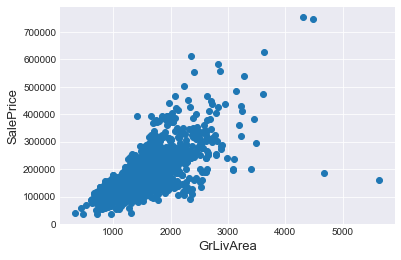

In [121]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

Можно обратить внимание на некоторые позиции, которые явно отличаются от общей закономерности. Уберем эти выбросы из данных.

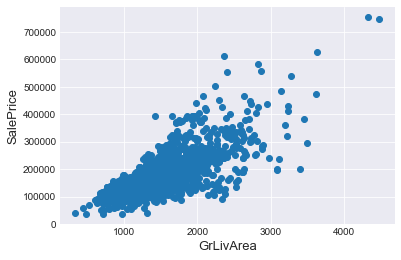

In [122]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>3800) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

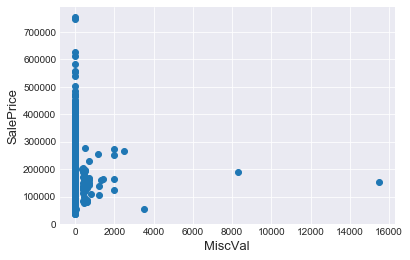

In [123]:
fig, ax = plt.subplots()
ax.scatter(train['MiscVal'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('MiscVal', fontsize=13)
plt.show()

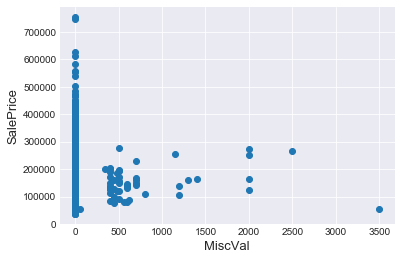

In [124]:
train = train.drop(train[(train['MiscVal']>3800) & (train['SalePrice']<300000)].index)
fig, ax = plt.subplots()
ax.scatter(train['MiscVal'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('MiscVal', fontsize=13)
plt.show()

### Целевая переменная

В ходе данной работы нам необходимо предсказать значение переменной SaltPrice. Проведем некоторый анализ данной переменной.
Для начала проверим, как распределена данная величина.


 mu = 180946.91 and sigma = 79518.25



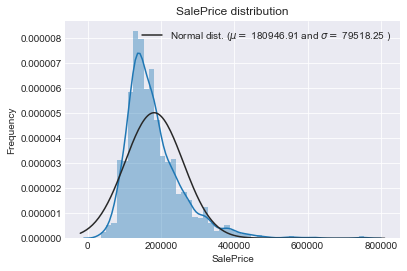

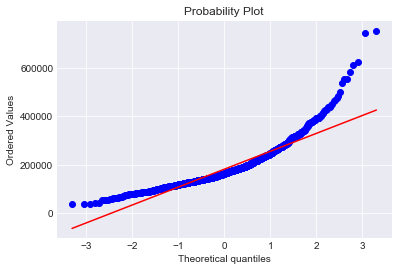

In [125]:
sns.distplot(train['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

Теперь необходимо преобразовать данную переменную так, чтобы она ближе аппроксимировалась нормальным распределением. Т.к. этого требуют линейные методы. Для этого применим преобразование логарифмирования.


 mu = 12.02 and sigma = 0.40



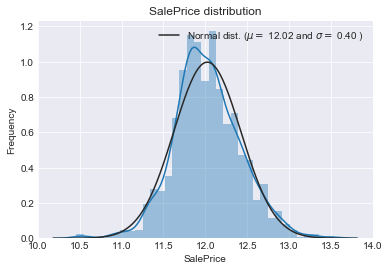

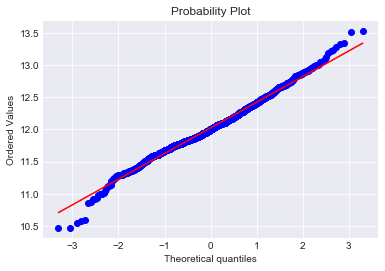

In [126]:
train["SalePrice"] = np.log1p(train["SalePrice"])
sns.distplot(train['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

## Обработка признаков 

In [127]:
#Сохраним Id и удалим этот признак, т. к. он совершенно бесполезен для предсказания
train_ID = train['Id']
test_ID = test['Id']
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [128]:
ntrain = train.shape[0]
ntest = test.shape[0]
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
y_train = train.SalePrice.values

Далее будем работать с незаполненными значениями

Text(0.5,1,u'Percent missing data by feature')

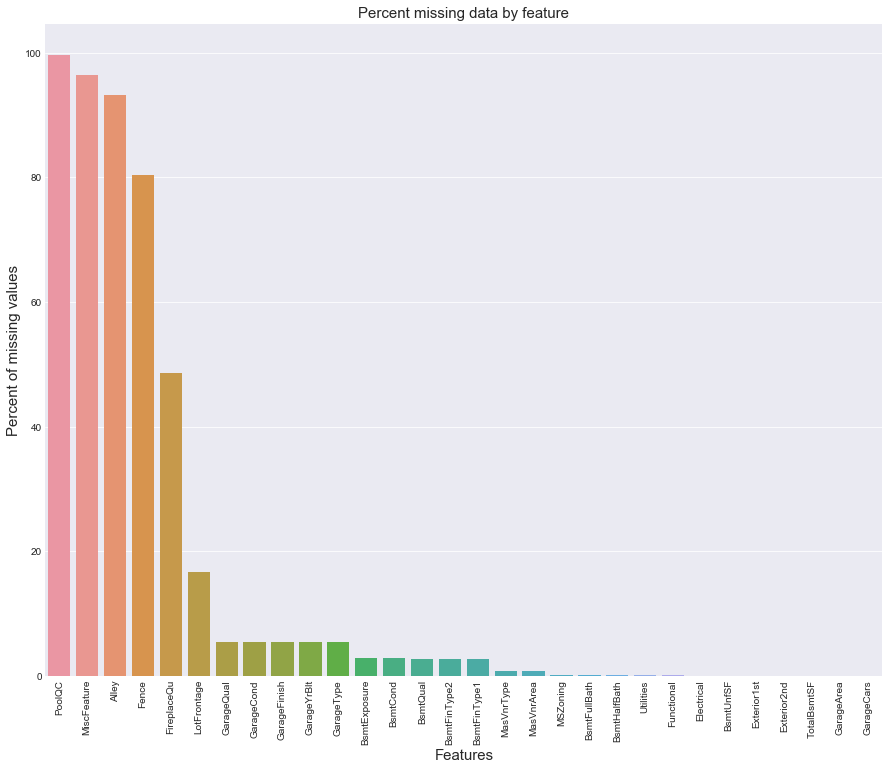

In [129]:

all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

Видим, что достаточное число признаков имеет большую часть незаполненных полей. Займемся обработкой данных значений.

In [130]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
mode_col = ['Electrical','KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
for col in mode_col:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")


In [131]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [132]:
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

### Обработка категориальных признаков

Для того, чтобы преобразовать значения категориальный признаков в числовые, будем использовать класс Label Encoder

In [133]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2915, 78)


Теперь проверим числовые признаки на сбалансированность

In [134]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head()


Skew in numerical features: 



,Skew
MiscVal,25.331
PoolArea,17.683
LotArea,13.115
LowQualFinSF,12.080
3SsnPorch,11.368


Будем использовать Box Cox - преобразование для обработки несбалансированных признаков.

In [135]:
skewness = skewness[abs(skewness) > 0.75]
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

In [136]:
all_data = pd.get_dummies(all_data)
train = all_data[:ntrain]
test = all_data[ntrain:]
train.shape

(1456, 218)

## Моделирование

Общий план действий такой: 
- Будем использовать модели (Lasso, Ridge, Gradient Boosting)
- Найдем величину CVScore
- Вычислим среднее на предсказании каждой модели

In [137]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [138]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)



In [139]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso score: 0.1127 (0.0076)



In [145]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1127 (0.0077)



In [146]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1175 (0.0086)



Обучим каждую модель

In [147]:
LassoMd = lasso.fit(train.values,y_train)
ENetMd = ENet.fit(train.values,y_train)
KRRMd = KRR.fit(train.values,y_train)
GBoostMd = GBoost.fit(train.values,y_train)

Найдем среднее.

In [148]:
finalMd = (np.expm1(LassoMd.predict(test.values)) + np.expm1(ENetMd.predict(test.values)) + np.expm1(KRRMd.predict(test.values)) + np.expm1(GBoostMd.predict(test.values)) ) / 4
finalMd

array([ 120429.04763362,  162361.98222181,  185371.37503574, ...,
        169568.97178347,  114351.18637224,  221494.89474188])

Запишем результаты в файл.

In [149]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = finalMd
sub.to_csv('sub.csv',index=False)

В ходе данной работы была решена проблема предсказания конечной стоимости недвижимости. С помощью несложной обработки признакового пространства, и с использованием простых моделей удалось войти в топ 13% лучших решений данного соревнования, что считатся довольно неплохим результатом. 